- 机器学习的目标是发现某些“模式”，而非简单地记住数据
- 将模型在训练数据上拟合的比在潜在分布中更接近的现象称为过拟合(overfitting),用于对抗过拟合的技术
称为正则化(regularization).

- K折交叉验证
  
当训练数据稀缺时，我们甚至可能无法提供足够的数据来构成一个合适的验证集。这个问题的一个流行的解
决方案是采用K折交叉验证。这里，原始训练数据被分成K个不重叠的子集。然后执行K次模型训练和验证，
每次在K − 1个子集上进行训练，并在剩余的一个子集（在该轮中没有用于训练的子集）上进行验证。最后，
通过对K次实验的结果取平均来估计训练和验证误差。

- 模型复杂度：参数数量、参数取值范围

- VC 维（VC Dimension）表示 假设类（Hypothesis Class）能够切分数据的能力，即该假设类可以 完美分类的最多样本点数。

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [9]:
from IPython import display
#@save
#计算预测正确的数量
def accuracy(y_hat,y): 
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y
    return float(cmp.type(y.dtype).sum())
#@save
#定义实用程序类Accumulator用于对多个变量的累加
class Accumulator: 
    """在多个变量上累加"""
    def __init__(self,n):
        self.data=[0.0]*n
    def add(self,*args):
        self.data=[a+float(b) for a,b in zip(self.data,args)]
    def reset(self):
        self.data=[0.0]*len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]
#@save
#对于任意数据迭代器data_iter可访问的数据集，评估在任意模型net的精度
def evaluate_accuracy(net,data_iter): 
    """计算在指定数据集上模型的精度"""
    if isinstance(net,torch.nn.Module):
        net.eval()
    metric=Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]
#@save
def train_epoch_ch3(net,train_iter,loss,updater):
    """训练模型一个迭代周期"""
    #将模型设置为训练模式
    if isinstance(net,torch.nn.Module):
        net.train()
    #训练损失总和、训练准确度总和、样本数
    metric=Accumulator(3)
    for X,y in train_iter:
        #计算梯度并更新参数
        y_hat=net(X)
        l=loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            #使用Pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            #使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
    return metric[0]/metric[2],metric[1]/metric[2]
#@save
#定义一个在动画中绘制数据的使用程序类Animator
class Animator: 
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None,xlim=None,ylim=None, xscale='linear', yscale='linear',fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = [] 
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self,x,y):
        #向图表中添加多个数据点
        if not hasattr(y,"__len__"):
            y=[y]
        n=len(y)
        if not hasattr(x,"__len__"):
            x=[x]*n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)
#@save
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater): 
    """训练模型"""
    animator=Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],
                      legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):
        train_metrics=train_epoch_ch3(net,train_iter,loss,updater)
        test_acc=evaluate_accuracy(net,test_iter)
        animator.add(epoch+1,train_metrics+(test_acc,))
    train_loss, train_acc = train_metrics
    """断言:用于确保训练和测试过程中某些性能指标（损失和准确率）符合预期"""
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc
#@save
#模型训练完成，对图像进行分类预测
def predict_ch3(net,test_iter,n=6): 
    """预测标签"""
    for X,y in test_iter:
        break
    trues=d2l.get_fashion_mnist_labels(y)
    preds=d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles=[true+'\n'+pred for true, pred in zip(trues,preds)]
    d2l.show_images(
        X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])

In [10]:
#生成数据集
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集大小
true_w = np.zeros(max_degree) # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [11]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
torch.float32) for x in [true_w, features, poly_features, labels]]

In [12]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.2425],
         [ 0.1788]]),
 tensor([[ 1.0000e+00, -2.4249e-01,  2.9400e-02, -2.3764e-03,  1.4406e-04,
          -6.9865e-06,  2.8236e-07, -9.7811e-09,  2.9647e-10, -7.9879e-12,
           1.9370e-13, -4.2699e-15,  8.6282e-17, -1.6094e-18,  2.7876e-20,
          -4.5063e-22,  6.8295e-24, -9.7416e-26,  1.3123e-27, -1.6749e-29],
         [ 1.0000e+00,  1.7884e-01,  1.5992e-02,  9.5332e-04,  4.2623e-05,
           1.5245e-06,  4.5441e-08,  1.1610e-09,  2.5953e-11,  5.1572e-13,
           9.2231e-15,  1.4995e-16,  2.2348e-18,  3.0743e-20,  3.9272e-22,
           4.6823e-24,  5.2336e-26,  5.5058e-28,  5.4703e-30,  5.1490e-32]]),
 tensor([4.5995, 5.3649]))

In [13]:
#对模型进行训练和测试
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [14]:
def train(train_features, test_features, train_labels, test_labels,
num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
    batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
    batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
    xlim=[1, num_epochs], ylim=[1e-3, 1e2],
    legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 5.011237   1.2117001 -3.4004972  5.5825596]]


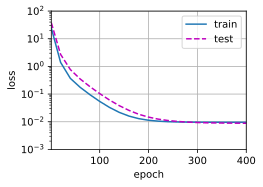

In [15]:
#三姐多项式拟合（正常）
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
labels[:n_train], labels[n_train:])

weight: [[3.3189995 3.897826 ]]


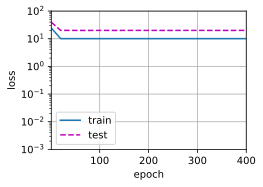

In [16]:
#线性函数拟合（欠拟合）
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
labels[:n_train], labels[n_train:])

weight: [[ 5.007537    1.282344   -3.3512127   5.1983924  -0.17568755  1.1470156
   0.25008735  0.27605706  0.22130348  0.11418106 -0.15563418  0.08050006
   0.12073917 -0.03164393 -0.13016886 -0.10565891 -0.12691122 -0.17692891
   0.01636873 -0.02960099]]


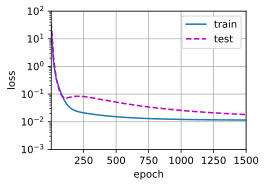

In [17]:
#高阶多项式函数拟合（过拟合）
# 从多项式特征中选取所有维度：过于复杂的模型会轻易受到训练数据中噪声的影响
train(poly_features[:n_train, :], poly_features[n_train:, :],
labels[:n_train], labels[n_train:], num_epochs=1500)